In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
import h5py
import shutil

from refnx.reduce import event
from platypus_eventer import analysis
from platypus_eventer.status import State, Status

In [3]:
# change NX, FRAME_FREQUENCY, OSCILLATION_PERIOD, SUBSUBFRAME_BIN_SZ, NBINS

NX = 277015
nxfile = f"QKK{NX:07d}"

with h5py.File(f"{nxfile}.nx.hdf", "r") as fi:
    pth = f"/{nxfile}/instrument/detector/daq_dirname"
    daq_dirname = fi[pth][:][0].decode()
    pth = f"/{nxfile}/instrument/detector/detector_y"
    detector_y = fi[pth][0]
    pth = f"/{nxfile}/instrument/nvs/status/wavelength"
    lamda = fi[pth][0]

print(f"{daq_dirname=}")

# frame frequency of signal generator
FRAME_FREQUENCY = 25.0  # Hz

# oscillation period of sample environment, expressed in terms of
# number of frames. e.g. if your FRAME_FREQUENCY is 25 Hz, and the
# oscillation of the sample environment is 0.5 Hz, then
# OSCILLATION_PERIOD should be 50, because one complete oscillation
# takes 50 frames. This value doesn't need to be exact.
OSCILLATION_PERIOD = 25.0

# How finely we divide up each frame. The frame period (1/FRAME_FREQUENCY)
# should be exactly divisible by this number. This value controls the
# sampling rate.
# For a 2 ms bin size the sampling rate will be 1/2e-3 = 500 Hz.
# Don't make this value smaller than the flight time uncertainty.
SUBFRAME_BIN_SZ = 2.0  # ms.

# How finely you would like to slice up the waveform. (i.e. how many scattering
# patterns in [0, 2*pi]?
NBINS = 50

daq_dirname='DAQ_2025-08-07T16-14-30'


In [4]:
# find out the maximum number of frames in the NEF
s = Status()
state = State(s.from_file(daq_dirname))
max_frames = state.dct["current_frame"]

In [5]:
# read SEF events into a list
events = analysis.read_events(daq_dirname)

# calculate which SEF frame corresponds to the first NEF
frame_offset = analysis.predicted_frame(daq_dirname)

# remove all events less than frame_offset or more than in NEF
events = [i for i in events if frame_offset <= i[0] < max_frames + frame_offset]

array search: 34, nearest time: 33


In [6]:
# extract data from the SEF

# meaning of columns:
# frame_no, time (ns), channel, voltage
# channel > 0 if entry is an ADC channel measuring the voltage
# channel < 0 if entry is a T0 pulse being recorded

# extract all the voltage measurement events
volts = [i[-1] for i in events if i[2] == 1]
volts = np.array(volts)
# the frame number corresponding to the voltage measurement events
f_sample = np.array([i[0] for i in events if i[2] == 1])

# the T0 frame numbers
f_t0 = np.array([i[0] for i in events if i[2] < 0])

# correct the SEF frame number so it lines up with the NEF
f_t0 -= frame_offset
f_sample -= frame_offset

# this assertion will fail if we missed one of the t0 pulses
assert len(f_t0) == max_frames
TOTAL_FRAMES = max_frames

print(f"Num T0 frame events = {TOTAL_FRAMES}")
print(f"Num sample events = {len(f_sample)}")

Num T0 frame events = 15002
Num sample events = 15002


In [7]:
# work out fractional location for when the voltage was measured within the frame
# This is necessary if we want to get precision much smaller than the frame period.

# times for each voltage sample and t0 pulse.
t_sample = [i[1] for i in events if i[2] == 1]
t_t0 = [i[1] for i in events if i[2] < 1]

_period = 1 / FRAME_FREQUENCY

f_sample_frac = np.zeros_like(f_sample, dtype=np.float64)
for i, _f_sample in enumerate(f_sample):
    _t_sample = t_sample[i]
    _idx = np.searchsorted(f_t0, _f_sample)
    _t_t0 = t_t0[_idx]
    f_sample_frac[i] = ((_t_sample - _t_t0) / 1e9) / _period

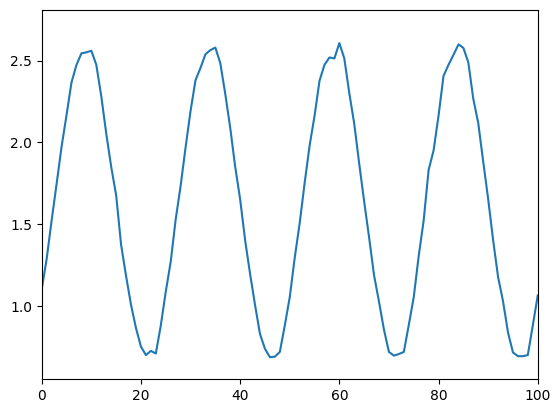

In [8]:
plt.plot(f_sample + f_sample_frac, volts)
plt.xlim(0, 100);

In [9]:
def wave(x, p):
    offset, amplitude, f0, osc_period = p
    return offset + amplitude * np.sin(phase(x, p))


def phase(x, p):
    x = np.asarray(x, np.float64)
    offset, amplitude, f0, osc_period = p
    return 2 * np.pi * (x - f0) / osc_period


def chi2(p, *args):
    x = args[0]
    y = args[1]
    ideal = wave(x, p)
    return np.sum((y - ideal) ** 2)

In [10]:
# fit a sine wave to the frame vs voltage information
# initial guesses
offset = np.mean(volts)
amplitude = 0.5 * (np.max(volts) - np.min(volts))
f0 = 11
osc_period = OSCILLATION_PERIOD

# initial guess vector
p0 = [offset, amplitude, f0, osc_period]

res = differential_evolution(
    chi2,
    bounds=[
        (0.9 * offset, 1.1 * offset),
        (0.9 * amplitude, 1.1 * amplitude),
        (-15, 15),
        (0.9 * OSCILLATION_PERIOD, 1.1 * OSCILLATION_PERIOD),
    ],
    args=(f_sample + f_sample_frac, volts),
)
offset, amplitude, f0, osc_period = p0 = res.x
OSCILLATION_PERIOD = osc_period
res.x

array([ 1.63521806,  0.95158565,  2.54896599, 25.00025694])

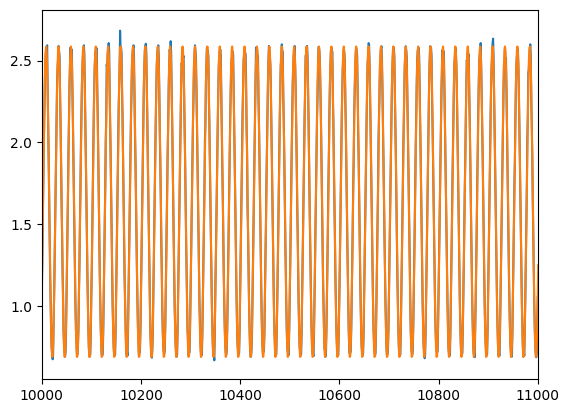

In [11]:
plt.plot(f_sample + f_sample_frac, volts)
plt.plot(f_t0, wave(f_t0, p0))
plt.xlim(10000, 11000);

In [12]:
# these specify the phases with the oscillation for which we wish to produce
# scattering curves. *They are bin edges*.
phase_bins = np.linspace(0, 2 * np.pi, NBINS + 1)
phase_bins

array([0.        , 0.12566371, 0.25132741, 0.37699112, 0.50265482,
       0.62831853, 0.75398224, 0.87964594, 1.00530965, 1.13097336,
       1.25663706, 1.38230077, 1.50796447, 1.63362818, 1.75929189,
       1.88495559, 2.0106193 , 2.136283  , 2.26194671, 2.38761042,
       2.51327412, 2.63893783, 2.76460154, 2.89026524, 3.01592895,
       3.14159265, 3.26725636, 3.39292007, 3.51858377, 3.64424748,
       3.76991118, 3.89557489, 4.0212386 , 4.1469023 , 4.27256601,
       4.39822972, 4.52389342, 4.64955713, 4.77522083, 4.90088454,
       5.02654825, 5.15221195, 5.27787566, 5.40353936, 5.52920307,
       5.65486678, 5.78053048, 5.90619419, 6.03185789, 6.1575216 ,
       6.28318531])

In [13]:
# Time bins for rebinning the TOF information within the NEF.
# Necessary if we wish to sample at a higher rate.
# These time bins control the sample period.
# If the time bin width is 2000 us, then the sampling rate is 500 Hz.

# From now on we use time bin/subframe interchangeably.

_period = 1000000 / FRAME_FREQUENCY  # microseconds
TIME_BINS = np.linspace(0, _period, int(_period / (1000 * SUBFRAME_BIN_SZ)) + 1)
TIME_BINS

array([    0.,  2000.,  4000.,  6000.,  8000., 10000., 12000., 14000.,
       16000., 18000., 20000., 22000., 24000., 26000., 28000., 30000.,
       32000., 34000., 36000., 38000., 40000.])

In [14]:
# load in the NEF
with open(f"{daq_dirname}/DATASET_0/EOS.bin", "rb") as f:
    nef = event.events(f)
    f_events, t_events, y_events, x_events = nef[0]
    t_events = np.asarray(t_events, np.uint32)
    y_events = np.asarray(y_events, np.uint32)
    x_events = np.asarray(x_events, np.uint32)

    # histogram/rebin the TOF data according to the time_bins
    # t_events will be a number in [0, len(TIME_BINS)). i.e.
    # an array index for which time bin the neutron is in.
    t_events = np.digitize(t_events, TIME_BINS) - 1
    _events = np.c_[f_events, t_events, y_events, x_events]

In [15]:
# Work out phase for each frame/subframe.
# Should have shape (N, T) where N is the total number of frames
# and T is the number of time bins/subframes.

_mid_subframe_bins = 0.5 * (TIME_BINS[1:] + TIME_BINS[:-1]) / _period
_frac_frames = f_t0[:, None] + _mid_subframe_bins[None, :]
print(_frac_frames.shape)

# Calculate the sine wave phase for each frame/subframe.
# Note, these are predicted phases based on the fitted model above. If the
# sine wave fit is poor, then the whole reduction falls over.

# ADD/SUBTRACT CONSTANT PHASE_OFFSET THAT REPRESENT THE FLIGHT TIME OF THE NEUTRONS
_neutron_speed = 3954 / lamda
_flight_time = (detector_y / 1000) / _neutron_speed
# proportion of frame that the flight time represents
_p = _flight_time / (1 / FRAME_FREQUENCY)
# proportion of SE oscillation that the flight time represents
_phase_offset = _p / OSCILLATION_PERIOD
# convert to radians
_phase_offset *= 2 * np.pi

# phase for each frame/{subframe, time bin}
frame_phases = (phase(_frac_frames, p0) - _phase_offset) % (2 * np.pi)

(15002, 20)


In [16]:
# Calculate where the phase of each of frames/subframes would land in the phase_bins.
# i.e. it specifies which detector image each frame/subframe each neutron will end up in.
bin_loc = np.digitize(frame_phases, phase_bins) - 1
bin_loc.shape

(15002, 20)

In [17]:
# make the detector image, N, Y, X
detector = np.zeros((NBINS, 192, 192), dtype=np.uint32)

In [18]:
# bin each neutron event into the detector image
# Remember that the tof information of the neutron events have already been digitised.
# i.e. t refers to the index of which time bin/subframe the event belongs to.

for i in _events:
    f, t, y, x = i
    det_idx = bin_loc[f, t]
    detector[det_idx, y, x] += 1

assert np.sum(detector) == len(_events)

In [24]:
frame_count_fraction = [np.count_nonzero(bin_loc==i) for i in range(NBINS)] / np.prod(bin_loc.shape)

In [25]:
def qkk_patcher(nxfile, detector, frame_count_fraction):
    for i in range(len(detector)):

        new_nxfile = f"QKK{i:07d}"
        shutil.copy(nxfile + ".nx.hdf", new_nxfile + ".nx.hdf")

        with h5py.File(f"{new_nxfile}.nx.hdf", "r+") as f:
            # rename group from the nxfile. For some reason Quokka is special
            # and the first child of the root node is named after the datafile
            f.move(f"/{nxfile}", f"/{new_nxfile}")

            # detector image
            dataset_name = f"/{new_nxfile}/data/hmm_xy"
            dset = f[dataset_name]
            dset[...] = detector[i]
            dset.attrs["target"] = f"/{new_nxfile}/instrument/detector/hmm_xy".encode()

            # total counts
            dataset_name = f"/{new_nxfile}/data/total_counts"
            dset = f[dataset_name]
            dset[...] = np.sum(detector[i])

            # total counts
            dataset_name = f"/{new_nxfile}/data/total_counts"
            dset = f[dataset_name]
            dset[...] = np.sum(detector[i])

            # measurement time
            dataset_name = f"/{new_nxfile}/instrument/detector/time"
            dset = f[dataset_name]
            t = dset[0]
            dset[...] = frame_count_fraction[i] * t

            ####################
            # beam monitor stuff
            ####################
            dataset_name = f"/{new_nxfile}/monitor/bm1_counts"
            dset = f[dataset_name]
            bm = dset[0]
            dset[...] = frame_count_fraction[i] * bm

            dataset_name = f"/{new_nxfile}/monitor/bm1_time"
            dset = f[dataset_name]
            bm = dset[0]
            dset[...] = frame_count_fraction[i] * bm

            dataset_name = f"/{new_nxfile}/monitor/bm2_counts"
            dset = f[dataset_name]
            bm = dset[0]
            dset[...] = frame_count_fraction[i] * bm

            dataset_name = f"/{new_nxfile}/monitor/bm2_time"
            dset = f[dataset_name]
            bm = dset[0]
            dset[...] = frame_count_fraction[i] * bm

            dataset_name = f"/{new_nxfile}/monitor/time"
            dset = f[dataset_name]
            bm = dset[0]
            dset[...] = frame_count_fraction[i] * bm

            dataset_name = f"/{new_nxfile}/monitor/data"
            dset = f[dataset_name]
            bm = dset[0]
            dset[...] = frame_count_fraction[i] * bm

In [26]:
qkk_patcher(nxfile, detector, frame_count_fraction)